# 3: Build and Train Transformer From Scratch (Keras)

# Setup and Installations

In [ ]:
# Setup and Installations
!pip install -q keras

# Imports and Initialization

In [ ]:
# Imports and Initialization
import keras
from keras import ops
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# 1. Implement Transformer Block

In [ ]:
# 1. Implement Transformer Block

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

# 2. Implement Token + Position Embedding

In [ ]:
# 2. Implement Token + Position Embedding

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# 3. Download and Prepare IMDB Dataset

In [ ]:
# 3. Download and Prepare IMDB Dataset

vocab_size = 20000
maxlen = 200

(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)

print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")

x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.utils.pad_sequences(x_val, maxlen=maxlen)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
25000 Training sequences
25000 Validation sequences


# 4. Build Transformer-based Classifier

In [ ]:
# 4. Build Transformer-based Classifier

embed_dim = 32  # Embedding size for each token
num_heads = 2   # Number of attention heads
ff_dim = 32     # Hidden layer size inside Transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)

transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 200, 32)        │       646,400 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 200, 32)        │        10,656 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 657,758 (2.51 MB)

 Trainable params: 657,758 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Compile and Train Model

In [ ]:
# 5. Compile and Train Model

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=5,
    validation_data=(x_val, y_val)
)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 135s 162ms/step - accuracy: 0.7030 - loss: 0.5311 - val_accuracy: 0.8804 - val_loss: 0.2822
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 134s 152ms/step - accuracy: 0.9101 - loss: 0.2236 - val_accuracy: 0.8728 - val_loss: 0.3138
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 126s 132ms/step - accuracy: 0.9442 - loss: 0.1493 - val_accuracy: 0.8615 - val_loss: 0.3968
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 160s 155ms/step - accuracy: 0.9638 - loss: 0.1057 - val_accuracy: 0.8502 - val_loss: 0.5692
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 151s 167ms/step - accuracy: 0.9755 - loss: 0.0746 - val_accuracy: 0.8425 - val_loss: 0.6247


# 6. Visualize Training Curves

# Accuracy plot

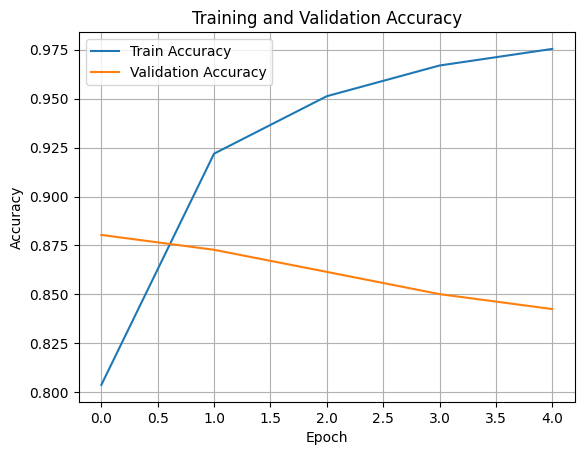

In [ ]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



# Loss plot

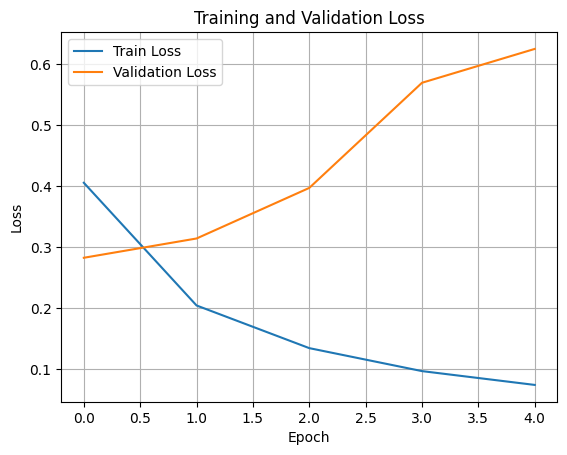

In [ ]:
# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ✅ Summary
print("""
In this notebook, I:
- Built a custom Transformer block and Token+Position Embedding.
- Loaded and prepared the IMDB movie reviews dataset.
- Built a text classifier model using the custom Transformer.
- Trained and evaluated the model.
- Visualized training accuracy and loss curves.
""")


In this notebook, I:
- Built a custom Transformer block and Token+Position Embedding.
- Loaded and prepared the IMDB movie reviews dataset.
- Built a text classifier model using the custom Transformer.
- Trained and evaluated the model.
- Visualized training accuracy and loss curves.

